## Objective 
Q1 - Is vine reviews worth the investment - i.e., do vine reviewers share the same sentiment as the regular users ? 
Q2 - weed out bad vine reviewers.
Q2 - trends in books
Q3 - Recommender

In [687]:
import pandas as pd
import numpy as np
import spacy
import nltk
import random

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,HashingVectorizer

from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.cluster import KMeans, MiniBatchKMeans#, SpectralClustering, MeanShift, AgglomerativeClustering
from sklearn import metrics

from textblob import TextBlob
from yellowbrick.text import TSNEVisualizer
from yellowbrick.cluster import InterclusterDistance
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('fivethirtyeight')

## Data Importing and Setup / Categorization

In [22]:
df_chunk = pd.read_csv('data-Project5/books.csv', iterator=False, chunksize=100000)

In [256]:
df_chunk.get_chunk()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
700000,US,19735815,R2SVJZBREMWIBG,1592408419,543673826,Daring Greatly: How the Courage to Be Vulnerab...,Books,5,0,0,N,N,highly recommended,Speed-read this in B&N today and it hit home o...,2015-06-28
700001,US,34971938,RM5NAGSSE12NT,0867166355,747725317,Francis And Clare in Poetry: An Anthology,Books,5,1,1,N,Y,Moves the Heart,I cannot recommend this book highly enough. It...,2015-06-28
700002,US,17476133,R11SURI66JASXA,1615797491,766302421,GOT A MINUTE PASTOR?,Books,4,0,0,N,Y,Being a pastor is not alway an easy life.,Good insight into the life of a busy pastor. W...,2015-06-28
700003,US,14121968,RZHHQ71BD1Q97,0761179542,771530478,For Women Who Do Too Much 2015 Page-A-Day Cale...,Books,5,0,0,N,Y,Buy one for a sister friend!,My daughter gave me the 2014 version as a Chri...,2015-06-28
700004,US,2599887,R3MXGIJ8BIWL02,0486476510,837651656,Color Your Own Japanese Woodblock Prints (Dove...,Books,5,17,17,N,Y,Five Stars,Beautiful illustrations and challenging select...,2015-06-28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,US,13536361,R2A215T5URFK5O,0688028411,876567179,Tiger Flower,Books,5,0,0,N,N,King of the Grass endures,I've had a copy of this book since I was a you...,2015-06-18
799996,US,985484,R3NLFWW73FB6B2,1442416890,661349080,City of Heavenly Fire (The Mortal Instruments),Books,5,0,0,N,Y,Five Stars,Love these books,2015-06-18
799997,US,12994817,RRCBGAUT4N5RP,1492602027,602166933,A Desperate Fortune,Books,5,0,0,N,N,Wonderful!,With the kiss of dual timelines Susanna Kears...,2015-06-18
799998,US,32855528,RJ5VSPKMLL3S8,0310701287,72874409,His First Bible,Books,5,0,0,N,Y,Nice book,Sweet gift for a baptism.,2015-06-18


In [24]:
def chunk_preprocessing(chunk, cols):
    chunk = chunk[cols]
    return pd.DataFrame(chunk)

In [318]:
cols = ['review_id', 'review_date', 'review_body', 'vine','verified_purchase', 'star_rating', 'customer_id', 'product_id']
df = chunk_preprocessing(df_chunk.get_chunk(), cols).set_index('review_id')
df = df[df.review_date != ''] # eliminating the reviews without a date.
display(df.shape)
df.head()

(100000, 7)

,review_date,review_body,vine,verified_purchase,star_rating,customer_id,product_id
review_id,,,,,,,
R2KYFH2IXTO2LS,2015-06-18,Beginners in JS will likely struggle with some...,N,Y,3,50803117,1118026691
R31IKMCDVV8F80,2015-06-18,great book,N,Y,5,29479327,0525478817
RTJ97FQ2M36PH,2015-06-18,Great book for helping children really learn w...,N,Y,5,33260364,0325001375
RCGXSB3JUGTHQ,2015-06-18,This book is wonderful. This author has spent ...,N,Y,5,10541543,0718022122
R1KS2IC6WOE71Y,2015-06-18,This novel strikes so close to home......I hav...,N,Y,5,4843786,1627984488


In [320]:
def plot_dist (df):
    fig, ax = plt.subplots()
    plt.title('Distribution of ratings', fontsize=15)
    sns.countplot(df.star_rating)
    ax.set_ylabel('No. of Ratings(Millions)')
    plt.show()

In [321]:
def date_filter(df, start, end):
    mask = (df.timestamp > pd.to_datetime(start)) & (df.timestamp < pd.to_datetime(end))
    df = df[mask]
    return df

In [322]:
### Filtering_into_subgroups
def vine_reviewers_rating_filter(df, max_rate=5, min_rate=4, vine='Y'):
    df = df[df.vine == vine]
    df = df[(df.star_rating >= min_rate) & (df.star_rating <= max_rate)]
    return df

1. Are vine users a good representation of the regular user

A. compare 4-5star rated topics between regular user and vine user

B. compare 1-3 star rated topics between regular user and vine user

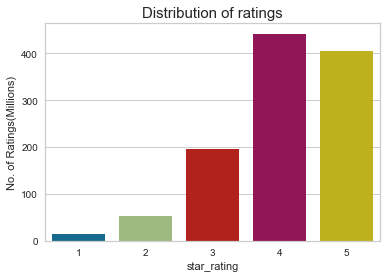

(1111, 7)

In [332]:
all_vine_user = vine_reviewers_rating_filter(df, max_rate=5, min_rate=1, vine='Y')
plot_dist(all_vine_user)
all_vine_user.shape

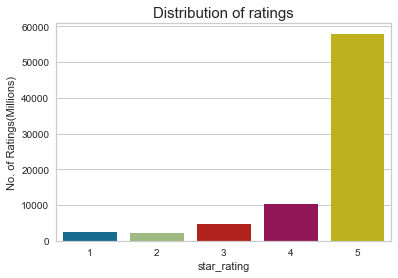

4.52548490687219

In [685]:
all_regular_user = vine_reviewers_rating_filter(df, max_rate=5, min_rate=1, vine='N')
all_regular_user = all_regular_user[all_regular_user.verified_purchase=='Y']
plot_dist(all_regular_user)
all_regular_user.star_rating.mean()

In [654]:
regular_user_low_rate = vine_reviewers_rating_filter(all_regular_user, max_rate=3, min_rate=1, vine='N')
display(regular_user_low_rate.shape)

(9568, 7)

In [328]:
regular_user_high_rate = vine_reviewers_rating_filter(all_regular_user, max_rate=5, min_rate=4, vine='N')
regular_user_high_rate.shape

(68282, 7)

In [329]:
vine_user_low_rate = vine_reviewers_rating_filter(all_vine_user, max_rate=3, min_rate=1, vine='Y')
vine_user_low_rate.shape

(263, 7)

In [331]:
vine_user_high_rate = vine_reviewers_rating_filter(all_vine_user, max_rate=5, min_rate=4, vine='Y')
vine_user_high_rate.shape

(848, 7)

In [334]:
all_vine_user.customer_id.nunique()

610

2. weed out the reviewer with a taste that doesnt match with the majority
vine user group by user - for each user 
identify 4-5 star rated topics and 1-3 star rated topics.

In [352]:
vine_user_count = all_vine_user.groupby(['customer_id'])['review_body'].count().reset_index(name='count')
vine_user_count = vine_user_count.sort_values('count', ascending=False)
vine_user_count = vine_user_count[vine_user_count['count']>=0]
#display(vine_user_count)
vine_user_id = list(vine_user_count['customer_id'].values)
display('Total number of vine reviewers', len(vine_user_id))
freq_vine_user_count = vine_user_count[vine_user_count['count']>=5]
display(freq_vine_user_count)
freq_vine_user_id = list(freq_vine_user_count['customer_id'].values)
display('Total number of frequent vine reviewers', len(freq_vine_user_id))


'Total number of vine reviewers'

610

,customer_id,count
310,46877221,38
473,51925793,18
78,21982343,11
217,39154578,9
384,50269104,9
515,52476646,9
593,53047657,9
563,52909137,9
221,39345823,9
497,52226443,8


'Total number of frequent vine reviewers'

40

In [351]:
# freq_vine_users_df = all_vine_user[all_vine_user.customer_id.isin(vine_user_id)]

# freq_vine_users_df_grouped = freq_vine_users_df.groupby(['customer_id'])['review_body'].count().reset_index(name='count')
# freq_vine_users_df_grouped = freq_vine_users_df_grouped.sort_values('count', ascending=False)
# freq_vine_users_df_grouped = freq_vine_users_df_grouped[freq_vine_users_df_grouped['count']>=5]
# len(freq_vine_users_df_grouped)


40

In [359]:
freq_vine_user_hr = freq_vine_users_df[freq_vine_users_df.star_rating>3]
freq_vine_user_hr_grouped = pd.DataFrame(freq_vine_user_hr.groupby(\
                    ['customer_id', 'star_rating','review_body'])\
                    ['star_rating'].count())
freq_vine_user_hr_grouped = freq_vine_user_hr_grouped.drop(columns=['star_rating'])

vine_user_hr_grouped.head()

Empty DataFrame
Columns: []
Index: [(10170543, 5, I grew up quite near Lancaster  with a keen appreciation and respect for the Amish people and their culture. Many like me seem to have taken their admiration further  writing  about Amish life in popular fiction. Too much of it is inaccurate at best  even trashy at worst. Not so with this story. It shows the Amish life as much like our own  with parents worrying over children  children worrying over parents  and everyone wanting to find where they best fit  what God has in mind for them. This story sorts life out for a number of people  young and older. It's a pleasant read and a nice visit back home in Amish country.), (10370146, 4, Run You Down was my first exposure to author Julia Dahl.  This 279-page novel is written from the perspective of a mother  Aviva Kagan  housekeeper and her daughter  Rebekah Roberts  a New York Tribune reporter  who do not know each other.  This tale leans heavily on Jewish terms  culture and rebellion.<br /><br />I found the need to take notes on the key elements to understand the interrelationships between characters  follow the storyline early on and slowly unravel this unusual  yet well-written mystery.<br /><br />Sam Kagan  Aviva’s youngest brother was sexually and mentally abused; however  silence for the sake of religion and family honor trumped justice.  His best friend since childhood  Pessie Goldin loved him as he did her; however  he discovered a man  Ryan Hall that he loved is a different way.<br /><br />Ryan  like Sam hated the family circumstance that he was born in.  Ryan’s father and brother are intolerant haters—dangerous anti-Semitic racists—who would never tolerate his sexual orientation.<br /><br />Pessie  married Saul Katz  a retired NYPD officer turned private inspector.<br /><br />The crux of this mystery centers on unraveling the circumstances of Pessie’s death—a suicide or murder and why--and developing relationship cultural and family relationships.<br /><br />I struggled at the onset  but quickly became intrigued and immersed in this unusual yet believable tale and learned a lot about the Jewish culture in the process.<br /><br />I recommend this author and story to those that are patient  open minded and willing to piece together a carefully unfolding mystery.<br /><br />Enjoy!), (10370146, 5, Taylor Stevens is one of my favorite authors.  I am not only amazed at the obstacles that she overcame during her childhood  but am more in awe of her ability to unfold riveting tales with intriguing characters that hold my interest from beginning to end.<br /><br />The Mask is one such tale.  Protagonist Vanessa Michael Munroe is a flawed woman who easily transforms to a convincing male persona. Though she and Miles Bradford have a special bond and romantic relationship  they are able to separate their missions from their personal lives.<br /><br />In this case Miles  owner of Capstone Security Consulting accepts a security assignment in Japan where he is hired by an Executive of a major Bio-medical/technology company—ALTEQ-Bio to uncover a spy responsible for stealing trade secrets.<br /><br />Withholding information from Monroe  Miles comes under attack from ALTEQ Security  the spy and the mob and is convincingly framed for a murder of an innocent employee.<br /><br />Enter Monroe  a master assassin and Mile’s subcontractor  replacing him while he is under wraps.<br /><br />A variety of bad guys underestimate Monroe’s brilliance  skills and willingness to die fighting for her cause.<br /><br />This action packed mystery kept me on the edge of my seat rapidly flipping pages from beginning to end and completely satisfied with a well-written novel.<br /><br />I wholeheartedly recommend this book to those who enjoy a riveting  action packed well-written mystery with intriguing characters.<br /><br />Enjoy!), (10927980, 4, This story is fairly typical Amish fiction  with young adults reaching a time when they need to decide if they w

In [360]:
vine_user_lr = vine_users_df[vine_users_df.star_rating<4]
vine_user_lr_grouped = pd.DataFrame(vine_user_lr.groupby(['customer_id', 'star_rating','review_body'])\
                    ['star_rating'].count()).drop(columns=['star_rating'])


vine_user_lr_grouped.head()


Empty DataFrame
Columns: []
Index: [(33376665, 3, I loved the New England setting ( being a 10 generation New Englander myself). However the mom and daughter were not appealing or interesting. The plot never became believable for me and the pace was rarely compelling. I have read rave reviews of the author's other books [[ASIN:0061095052 A Woman's Place]]; [[ASIN:1416579567 Coast Road]]; [[ASIN:B00F1QX852 The Dream (Crosslyn Rise Trilogy Book 1)]]; [[ASIN:1451648413 Lake News]]; [[ASIN:B000OF06QE TOGETHER ALONE -OS]]so I will try another.), (33376665, 3, I was hoping for something fun to read and it started off great. We learn about her family and her home and her obsessions and fears. I visited the Dickinson home in October 2014 so this novel was a real treat.<br /><br />The family hires a new maid  an Irish immigrant  Ada.  Emily soaks up all things Ada. The story turns dark after this point for Ada. I think I would have enjoyed it more without the angst. Ada and Emily alternate telling the story  I have found that  for me  when this format is used I tend to not feel enmeshed in the characters and his was no exception - they just seem to come out a bit hollow.), (37337835, 2, I thought this book would never end  and when it did  I suspected that there would be a sequel. For me  that is not good news. I feel all there needed to be said about these Kardashian-types had already been said. Too many characters with nothing of importance to offer. Acquisition of pretty stuff -- lots of it  but I didn't care about the acquisition because I didn't care about the characters doing the acquiring. However  the cover is gorgeous!), (37337835, 3, At first I thought I could move through the reaction a lot of readers had to I Take You: A Novel. Be warned  this is not your average chick-lit. I wanted to like the character and forgive her anything because I knew this was a comedic novel that was designed to entertain. However  the more I read the less I found to like to the point that even as I sometimes chuckled I was also disturbed. In essence  I will say read it at your own risk  knowing that you may very well be disturbed by the heroine. Meh.), (37337835, 3, Eyes on You is a flashy quick read for people who like flashy quick TV mysteries. People are wearing great clothes and have great hair. Fake boobs enter the room before the woman does. Great shoes. Lots  really. The story is not one that will keep you up all night wondering about what will happen next  but it is a fun (and did I mention flashy) read. It's almost interchangeable with any mystery drama you've seen in the last several years. If this describes what you are looking for  you will most assuredly find it here. Not bad  but it is what it is.)]

In [367]:
most_reviewed_vine_cus = freq_vine_users_df[freq_vine_users_df.customer_id==46877221]
len(most_reviewed_vine_cus)
most_reviewed_vine_cus.iloc[0,:]

review_date                                                 2015-06-18
review_body          This has humor and it has a dark side.  The se...
vine                                                                 Y
verified_purchase                                                    N
star_rating                                                          4
customer_id                                                   46877221
product_id                                                  0062364839
Name: R1ETM5M793D1SJ, dtype: object

## Text Preprocessing

1. change product_title to review body
2. date separations monthwise

Plan
3. separate vine vs non-vine topics
4. text preprocessing - with spacy / nltk.

In [657]:
reguluar_users_corpus = pd.DataFrame(all_regular_user, columns=['review_body', 'star_rating'])
reguluar_users_corpus = reguluar_users_corpus.dropna()
len(reguluar_users_corpus)
reguluar_users_corpus.head()

,review_body,star_rating
review_id,,
R2KYFH2IXTO2LS,Beginners in JS will likely struggle with some...,3
R31IKMCDVV8F80,great book,5
RTJ97FQ2M36PH,Great book for helping children really learn w...,5
RCGXSB3JUGTHQ,This book is wonderful. This author has spent ...,5
R1KS2IC6WOE71Y,This novel strikes so close to home......I hav...,5


### Test Cleaning

In [ ]:
def text_cleaning(corpus):
    

### Adding Stop Words

In [658]:
additional_stop_words = ['fascinating', 'enthralling', 'engrossing', 'nice', 
                            'people','youre', 'wa', 'book', 'good', 'buy', 'bought', 
                            'ok', 'better', 'best', 'help', 'little', 'br',
                            'br br', 'author', 'book br', 'ha', 'expected', 'wasn',
                            'okay', 'quite', 'story', 'really', 'didn', 'little',
                            'information', 'disappointed', 'read', 'interesting', 
                            'read book', 'hard', 'easy', 'page', 'cover', 'small',
                            'missing', 'quality', 'helpful', 'feel', 'description', 'great', 'good', 'better', 'best'
                            'enjoy', 'boring', 'poorly']


In [659]:
from spacy import displacy
from itertools import chain
import itertools

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

def add_stop_words(doc):
    new_stop_words_ = []
    for t in doc:
            if (t.pos_ == 'ADJ') or (t.pos_ == 'ADV'):
                new_stop_words_.append(t)
    return list(set(new_stop_words_))

new_stop_words = []
for doc in nlp.pipe(corpus.review_body):
    new_stop_words = itertools.chain(new_stop_words, add_stop_words(doc))




In [660]:
for i in new_stop_words:
    additional_stop_words.append(i)

additional_stop_words = list(set(additional_stop_words))
len(additional_stop_words)

81088

In [661]:
stop_words = text.ENGLISH_STOP_WORDS.union(my_additional_stop_words)

### bigrams

In [595]:
def bigrams(words, bi_min=15, tri_min=10):
    bigram = gensim.models.Phrases(words, min_count = bi_min)
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    return bigram_mod

### Testing Spacy
#### Spacy to get parts of speech (pos_) and dependency (dep_)


#### Spacy nlp.pipe to process documents

In [596]:
# %%time
# from spacy import displacy
# nlp = spacy.load('en_core_web_sm')

# def text_preprocess(text):
#     doc = nlp(text)
#     for t in doc:
#         if t.lower_ in ['awesome', 'super', 'excellent']:
#             if t.pos_ != 'NOUN' :
#                 if t.dep_ != 'amod':
#                     return True
#     return False

# #generator
# new_corpora = (i for i in corpus if text_preprocess(i))
# [next(new_corpora) for i in range (3)]

In [597]:
# sentence = "The book was super interesting."
# displacy.render(nlp(sentence))
# #spacy.explain("acomp")

### Lemmatize and Stemming

In [662]:
def spacy_lemma(texts, allowed_postags=['NOUN','ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [599]:
articles['doc_text']=''
articles['doc_adj_only'] = ''
articles['doc_length'] = 0

articles['title_text']=''
for tup in articles.itertuples():
    doc = nlp(tup.text)
    articles.at[tup.Index,'doc_length'] = len(doc)
    
    token_list = [token.lemma_ for token in doc if ((token.pos_ not in ['SYM','SPACE','PUNCT','NUM'])
    and (token.lemma_ != '-PRON-') and (token.text.lower() not in stop))]
    token_str = ' '.join(token_list)
    articles.at[tup.Index,'doc_text'] = token_str

NameError: name 'articles' is not defined

In [663]:
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
snowball_stem = SnowballStemmer('english')
lancaster_stem = LancasterStemmer('english')

from nltk import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [664]:
def snowball(text):
    return ' '.join([snowball_stem.stem(word) for word in text.split(' ')])

def lancaster(text):
    return ' '.join([lancaster_stem.stem(word) for word in text.split(' ')])

def lemmatize(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split(' ')])

In [666]:
display(len(reguluar_users_corpus.review_body))
reguluar_users_corpus.head()

77844

,review_body,star_rating
review_id,,
R2KYFH2IXTO2LS,Beginners in JS will likely struggle with some...,3
R31IKMCDVV8F80,great book,5
RTJ97FQ2M36PH,Great book for helping children really learn w...,5
RCGXSB3JUGTHQ,This book is wonderful. This author has spent ...,5
R1KS2IC6WOE71Y,This novel strikes so close to home......I hav...,5


In [667]:
reguluar_users_corpus['snowball'] = reguluar_users_corpus.review_body.apply(snowball)

In [668]:
#corpus['lancaster'] = corpus.review_body.apply(lancaster)

In [669]:
reguluar_users_corpus['lemmatized'] = reguluar_users_corpus.review_body.apply(lemmatize)

In [671]:
reguluar_users_corpus.head()

,review_body,star_rating,snowball,lemmatized
review_id,,,,
R2KYFH2IXTO2LS,Beginners in JS will likely struggle with some...,3,beginn in js will like struggl with some of th...,Beginners in JS will likely struggle with some...
R31IKMCDVV8F80,great book,5,great book,great book
RTJ97FQ2M36PH,Great book for helping children really learn w...,5,great book for help children realli learn what...,Great book for helping child really learn what...
RCGXSB3JUGTHQ,This book is wonderful. This author has spent ...,5,this book is wonderful. this author has spent ...,This book is wonderful. This author ha spent h...
R1KS2IC6WOE71Y,This novel strikes so close to home......I hav...,5,this novel strike so close to home......i have...,This novel strike so close to home......I have...


### Countvectorizer and TFIDF

In [672]:
vec_tfidf = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2), min_df=0.01, max_df=0.1)
X_tfidf = vec_tfidf.fit_transform(corpus.lemmatized)

In [673]:
vec_cv = CountVectorizer(stop_words=stop_words, ngram_range=(1,2), min_df=0.01, max_df=0.1)
X_cv = vec_cv.fit_transform(corpus.lemmatized)

cv_corpus = pd.DataFrame(X_cv.toarray(), columns=vec_cv.get_feature_names(), index=corpus.lemmatized.index)

## Topic Modeling

### NMF

In [674]:
def nmf_test(X, vec, dim):
    
    nmf = NMF(dim, random_state=12)
    nmf_topic = nmf.fit_transform(X)
    nmf_word = pd.DataFrame(nmf.components_.round(5),
                           index=np.arange(1,dim+1),
                           columns=vec.get_feature_names())
    topics = nmf_word.transpose()
    
    for i, cat in enumerate(topics.columns):
        keywords = topics.loc[:,cat].sort_values(ascending=False).head(5)
        print(f'{i}: {keywords.index.values}\n')
        
    return nmf, nmf_topic

In [675]:
review_topics, review_weights = nmf_test(X_tfidf, vec_tfidf, 6)

0: ['reading' 'way' 'make' 'character' 'written']

1: ['great' 'condition' 'came' 'picture' 'used']

2: ['thought' 'expecting' 'going' 'writing' 'instead']

3: ['did' 'enjoy' 'useful' 'description' 'care']

4: ['money' 'waste' 'waste money' 'don' 'time']

5: ['lot' 'helpful' 'looking' 'recipe' 'use']



In [676]:
review_topics

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
    n_components=6, random_state=12, shuffle=False, solver='cd', tol=0.0001,
    verbose=0)

In [677]:
topic_map = {
    0: 'Writing Quality',
    1: 'Delivery & Condition',
    2: 'Meeting Expectation',
    3: 'Enjoyable',
    4: 'Price_concious',
    5: 'Helpfulness'
}

In [678]:
corpus['topic'] = review_weights.argmax(axis=1)
corpus['topic_name'] = corpus.topic.map(topic_map)

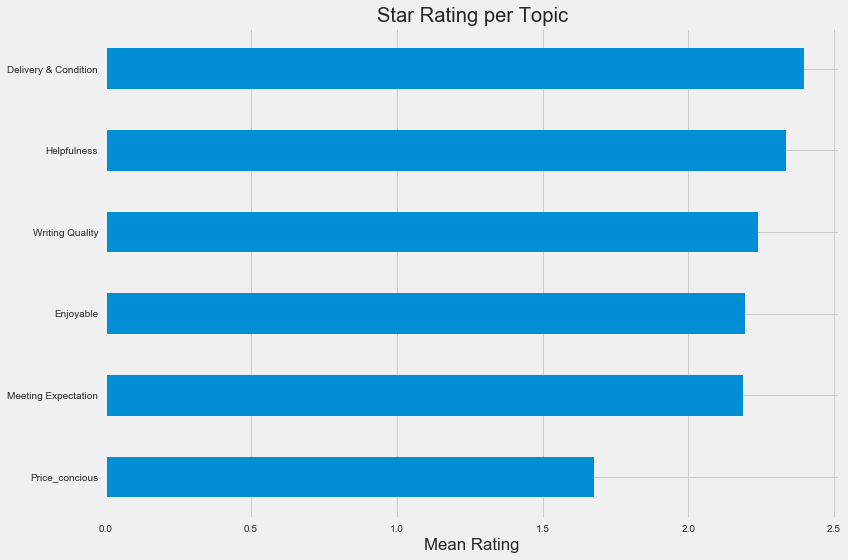

In [691]:
plt.figure(figsize=(12, 8))
topic_stars_grouped = corpus.groupby('topic_name').star_rating.mean().sort_values()
# tds_data.groupby('topic_name').claps.mean().sort_values().plot(kind='barh')
topic_stars_grouped.plot(kind='barh')
plt.xlabel('Mean Rating')
plt.ylabel('')
plt.title('Star Rating per Topic')
plt.tight_layout()
# plt.savefig('median_claps_topic.svg');

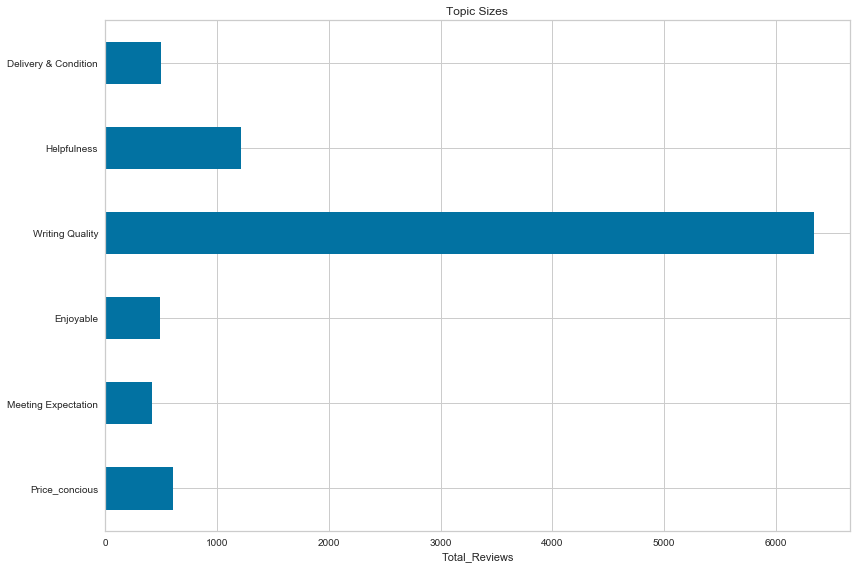

In [648]:
plt.figure(figsize=(12, 8))
corpus.groupby('topic_name').topic.count()[topic_stars_grouped.index].plot(kind='barh')
plt.xlabel('Total_Reviews')
plt.ylabel('')
plt.title('Topic Sizes')
plt.tight_layout()
# plt.savefig('topic_sizes.svg');

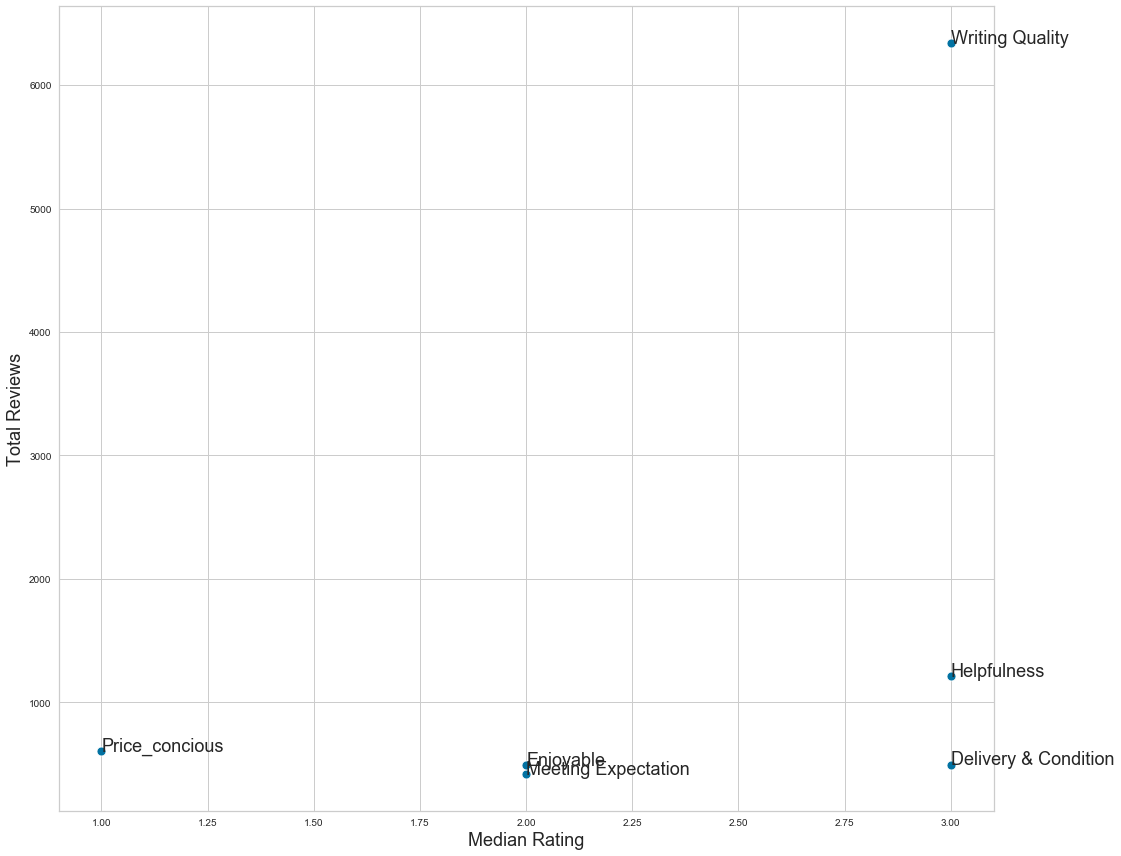

In [649]:
plt.figure(figsize=(14,12))
data = corpus.groupby('topic').agg({'star_rating':'median', 'review_body':'count'}).sort_index()
data['name'] = data.index.map(topic_map)
sns.scatterplot(x='star_rating', y='review_body', data=data, s=80)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']), size=18)

label_point(data.star_rating, data.review_body, data.name, plt.gca())

plt.xlabel('Median Rating', size=18)
plt.ylabel('Total Reviews', size=18)
plt.tight_layout()
# plt.savefig('article_clap_scatter.svg');




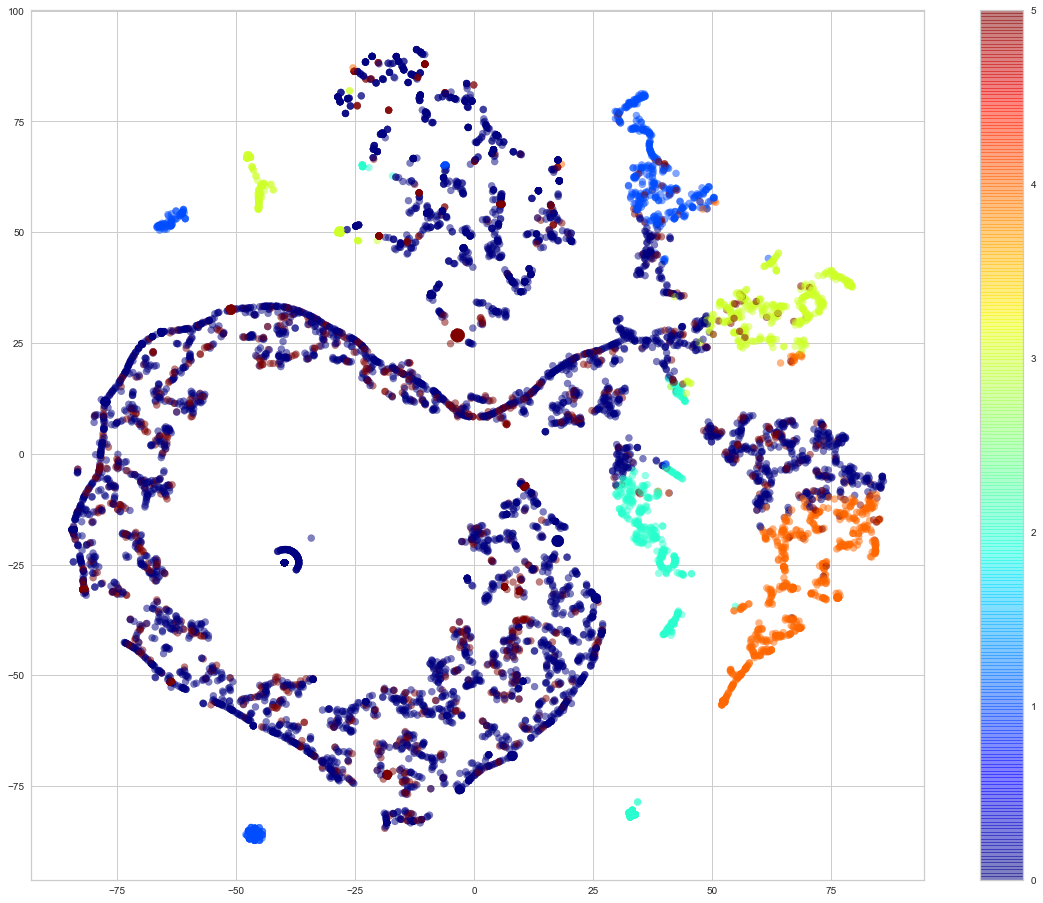

In [650]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0, verbose=0)
low_data = model.fit_transform(nmf_sc)

plt.figure(figsize=(20,16))

plt.scatter(low_data[:,0], low_data[:,1], c=corpus.topic, cmap='jet', alpha=.5)
plt.colorbar();

## Visualization

In [651]:
nmf_sc = StandardScaler().fit_transform(review_weights)
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=12)
nmf_pca = pca.fit_transform(nmf_sc)

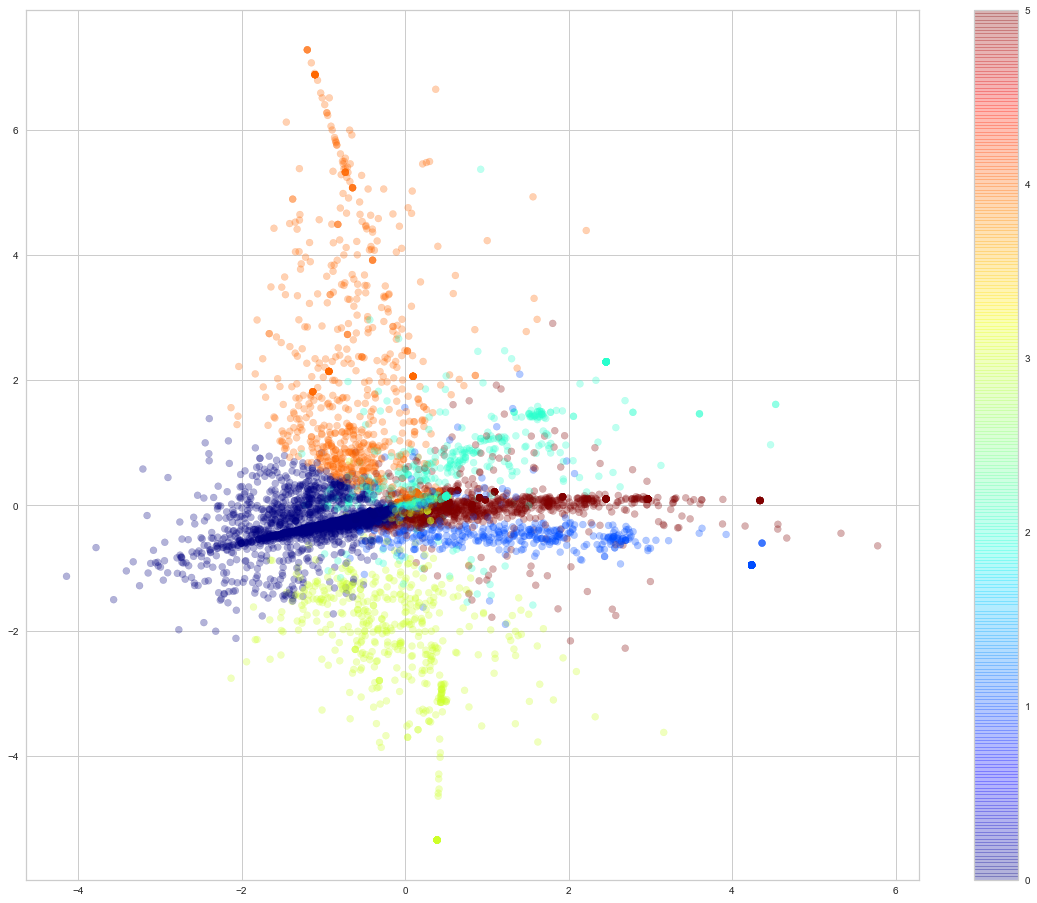

In [652]:
plt.figure(figsize=(20,16))
plt.scatter(nmf_pca[:,0], nmf_pca[:,1], c=nmf_sc.argmax(axis=1), cmap='jet', alpha=0.3)
plt.colorbar();

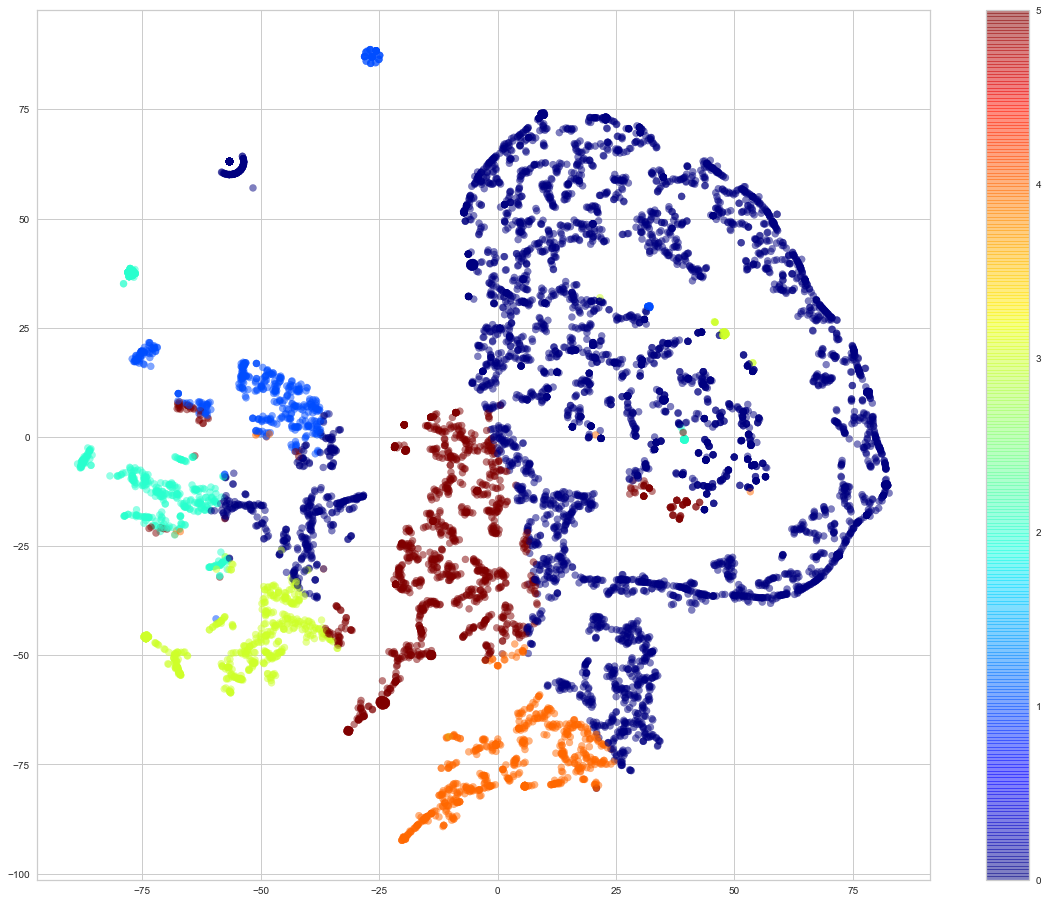

In [653]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=20, verbose=0)
low_data = model.fit_transform(nmf_sc)

plt.figure(figsize=(20,16))

plt.scatter(low_data[:,0], low_data[:,1], c=corpus.topic, cmap='jet', alpha=.5)
plt.colorbar();

In [7]:
chunk_list = []
for chunk in df_chunk:  
    pp_chunk = chunk_preprocessing(chunk)
    chunk_list.append(pp_chunk)
df_concat = pd.concat(chunk_list)

KeyboardInterrupt: 